In [33]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks

In [34]:
patient = 2
cgmSeries = pd.read_csv("DataFolder/CGMDatenumLunchPat" + str(patient) + ".csv")
cgmData = pd.read_csv("DataFolder/CGMSeriesLunchPat" + str(patient) + ".csv")
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
# cgmData.dropna()
insulinBasal = pd.read_csv("DataFolder/InsulinBasalLunchPat" + str(patient) + ".csv")
insulinBasal = insulinBasal.fillna(0)
insulinBolus = pd.read_csv("DataFolder/InsulinBolusLunchPat" + str(patient) + ".csv")
insulinBolus = insulinBolus.fillna(0)
insulinTime = pd.read_csv("DataFolder/InsulinDatenumLunchPat" + str(patient) + ".csv")
# print(insulinBasal.table)

In [35]:
reading_no = 1
# Normalize CGMValues
cgmValues_np = cgmData.values
cgmNorm_np = pre.minmax_scale(cgmValues_np, axis=1)

# CGM Timeseries
cgmSeries_np = cgmSeries.values
timeMins = np.nanmin(cgmSeries_np, axis=1)
cgmSeries_np = cgmSeries_np - timeMins[:, None]

# Normalize insulinBasal
insulinBasal_np = insulinBasal.values
insulinBasalNorm_np = pre.minmax_scale(insulinBasal_np, axis=1)

# Normalize insulinBolus
insulinBolus_np = insulinBolus.values
insulinBolusNorm_np = pre.minmax_scale(insulinBolus_np, axis=1)

# Insluin Timeseries
insulinTime_np = insulinTime.values - timeMins[:, None]

C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [36]:
# Slope between max and min
maxs = np.argmax(cgmNorm_np, axis=1)
mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

slopes = []
time_diffs = []
for i in range(len(maxs)):
    slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    time_diffs.append(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    slopes.append([slope])
    
slopes = np.nan_to_num(slopes)
time_diffs = np.nan_to_num(time_diffs)

C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [37]:
# Velocity Computation
window_size = 5
vels = []
for j in range(len(cgmNorm_np)):
    velocities = []
    for i in range(len(cgmNorm_np[j])-window_size):
        velocity = lr(cgmNorm_np[j][i:i+window_size], cgmSeries_np[j][i:i+window_size])
        velocities.append(velocity[0])
    vels.append(velocities)
vels = np.nan_to_num(vels)

C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= sel

In [38]:
# Acceleration Computation
accs = []
for j in range(len(vels)):
    accelerations = []
    for i in range(len(vels[j])-window_size):
        acceleration = lr(vels[j][i:i+window_size], cgmSeries_np[j][i+1:i+1+window_size])
        accelerations.append(acceleration[0])
    accs.append(accelerations)
accs = np.nan_to_num(accs)

In [39]:
# Regression Error
reg_window_size = 6
reg_errors = []
peak_values = []
peak_heights = []
peak_time_diffs = []
peak_times = []
for j in range(len(cgmNorm_np)):
    errors = np.array([])
    for i in range(len(cgmNorm_np[j])-reg_window_size):
        times = cgmSeries_np[j][i:i+reg_window_size-1]
        coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
        poly = np.poly1d(coeffs)
        error = poly(cgmSeries_np[j][i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
        errors = np.append(errors, error)
    peaks, height_dict = find_peaks(errors, height = 0)
    heights = height_dict['peak_heights']
    sorted_args = heights.argsort()
    peaks = peaks[sorted_args]
    peaks = peaks[-2:]
    heights = heights[sorted_args]
    heights = heights[-2:]
    values = cgmNorm_np[j][peaks+reg_window_size-1]
    times = cgmSeries_np[j][peaks+reg_window_size]
    times2 = cgmSeries_np[j][peaks+reg_window_size-1]
    reg_errors.append(errors)
    peak_values.append(values)
    peak_heights.append(heights)
    peak_time_diffs.append(times)
    peak_times.append(times2)
reg_errors = np.array(reg_errors)

LinAlgError: SVD did not converge in Linear Least Squares

[13.08892607]
0.07640046207234263


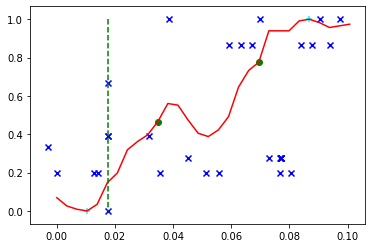

[0.77586207 0.46551724]
[0.16034482 0.27602586]
[0.06945602 0.03472222]


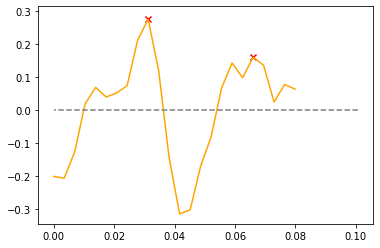

         min      mean       max      next       var
26  0.491379  0.717241  0.939655  1.000000  0.027289
25  0.422414  0.613793  0.775862  0.991379  0.023276
24  0.387931  0.536207  0.732759  0.939655  0.021938
[28.80000027]
0.03472222189884633


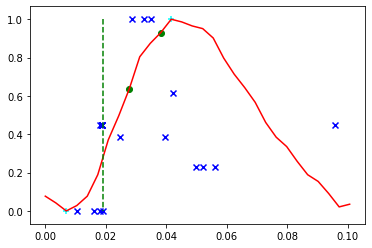

[0.93006993 0.63636364]
[0.17902098 0.22657343]
[0.03819444 0.02777778]


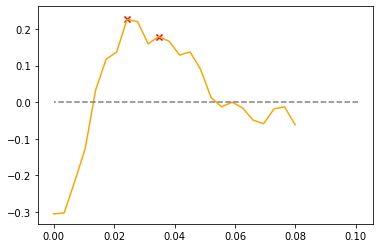

         min      mean       max      next       var
14  0.188811  0.499301  0.804196  0.986014  0.056179
13  0.076923  0.353846  0.636364  1.000000  0.051093
15  0.370629  0.636364  0.874126  0.965035  0.043719
[26.18181847]
0.0381944440305233


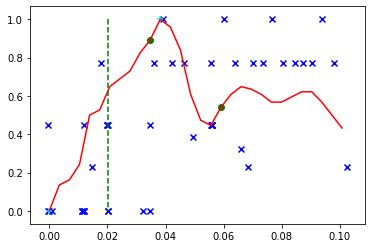

[0.54054054 0.89189189]
[0.21621622 0.51261729]
[0.0590625  0.03472222]


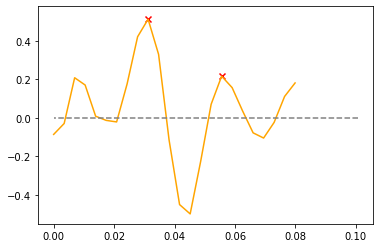

         min      mean       max      next       var
20  0.472973  0.775676  1.000000  0.648649  0.051917
21  0.445946  0.664865  0.959459  0.635135  0.051169
11  0.162162  0.416216  0.648649  0.891892  0.041947
[0.]
0.0


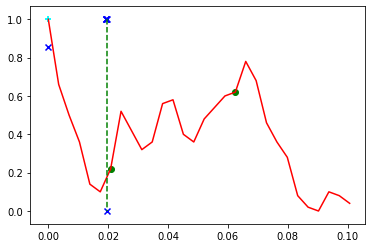

[0.22 0.62]
[0.328      0.43999998]
[0.02083333 0.0625    ]


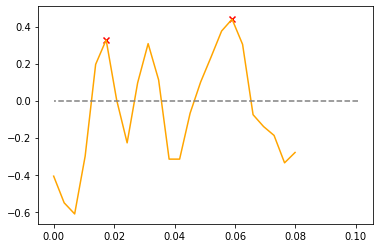

     min   mean   max  next      var
9   0.14  0.532  1.00  0.42  0.10492
8   0.36  0.704  1.00  0.52  0.08428
10  0.10  0.352  0.66  0.32  0.05632
[12.00000006]
0.08333333290647715


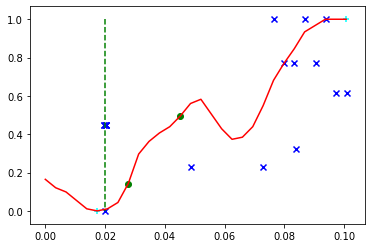

[0.14285714 0.49450549]
[0.16703296 0.26153847]
[0.02777778 0.04513889]


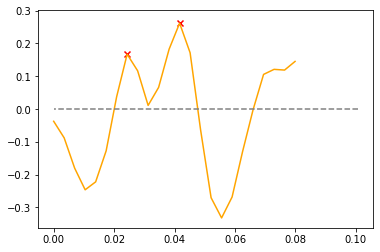

         min      mean       max     next       var
29  0.439560  0.657143  0.846154  1.00000  0.026953
28  0.384615  0.564835  0.769231  1.00000  0.025939
15  0.010989  0.171429  0.362637  0.56044  0.023765
[19.20000007]
0.0520833331393078


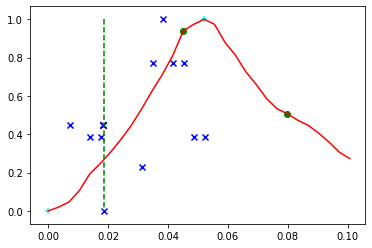

[0.50666667 0.94      ]
[0.03333333 0.29066668]
[0.07988426 0.04513889]


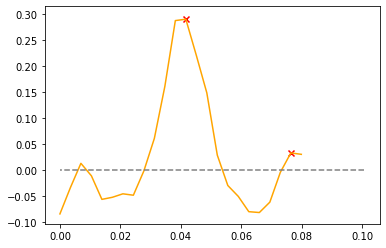

         min      mean       max      next       var
18  0.533333  0.725333  0.940000  0.880000  0.025142
19  0.626667  0.813333  0.973333  0.813333  0.021622
17  0.446667  0.626667  0.813333  0.973333  0.020867
[15.9970376]
0.06251157401129603


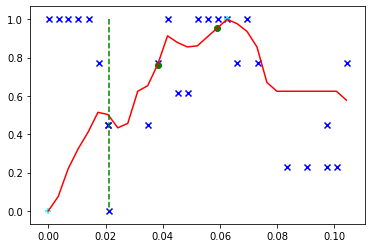

[0.76300578 0.95375723]
[0.2416185  0.29248556]
[0.03820602 0.05903935]


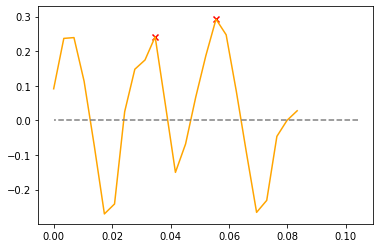

         min      mean       max      next       var
8   0.000000  0.205780  0.410405  0.456647  0.028845
9   0.075145  0.308671  0.514451  0.624277  0.028845
16  0.456647  0.682081  0.913295  0.907514  0.028751
[19.19147032]
0.052106481860391796


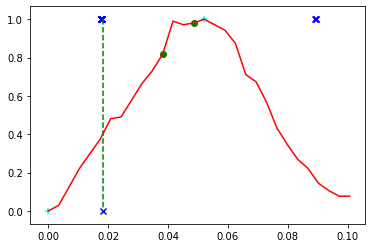

[0.98076923 0.81730769]
[0.19807694 0.25576923]
[0.04863426 0.03821759]


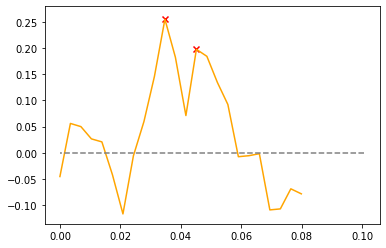

         min      mean       max      next       var
27  0.432692  0.651923  0.875000  0.144231  0.027247
29  0.269231  0.457692  0.673077  0.076923  0.026747
17  0.576923  0.755769  0.990385  0.971154  0.024991
[26.18181855]
0.03819444391410798


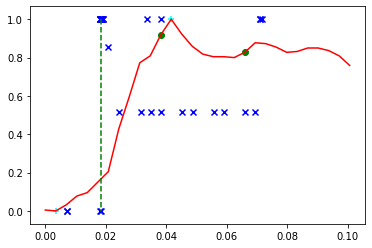

[0.82727273 0.91818182]
[0.10727273 0.27      ]
[0.06597222 0.03819444]


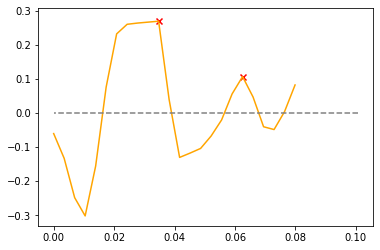

         min      mean       max      next       var
14  0.150000  0.430000  0.772727  0.922727  0.068519
15  0.204545  0.561818  0.809091  0.859091  0.063126
13  0.095455  0.294545  0.595455  1.000000  0.044198
[22.1538461]
0.045138888992369175


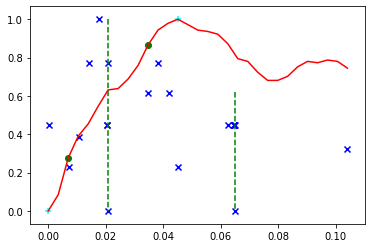

[0.27659574 0.86524823]
[0.17730496 0.21134752]
[0.00694444 0.03472222]


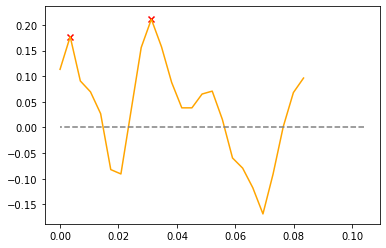

         min      mean       max      next       var
8   0.000000  0.241135  0.453901  0.687943  0.037800
9   0.085106  0.350355  0.546099  0.758865  0.031603
10  0.276596  0.459574  0.631206  0.865248  0.018822
[35.38983262]
0.0138888880610466


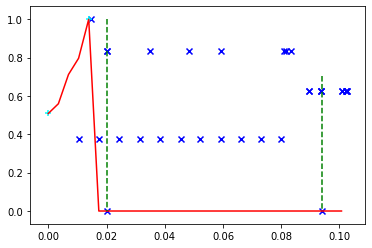

[]
[]
[]


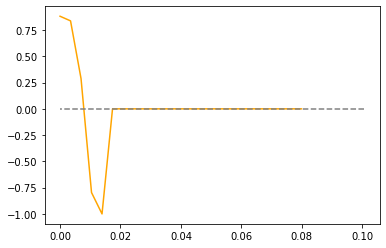

    min      mean  max  next       var
12  0.0  0.359322  1.0   0.0  0.247257
11  0.0  0.501695  1.0   0.0  0.220712
13  0.0  0.200000  1.0   0.0  0.200000
[23.99999982]
0.041666666977107525


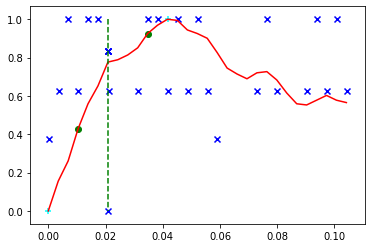

[0.92546584 0.42857143]
[0.17267081 0.19875779]
[0.03472222 0.01041667]


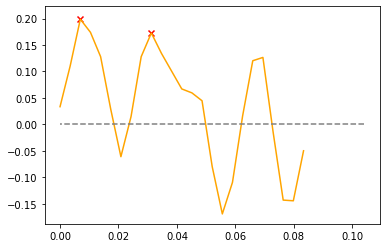

        min      mean       max      next       var
8   0.00000  0.280745  0.559006  0.813665  0.048559
9   0.15528  0.411180  0.652174  0.850932  0.042078
10  0.26087  0.535404  0.776398  0.925466  0.039763
[10.66534996]
0.09376157401129603


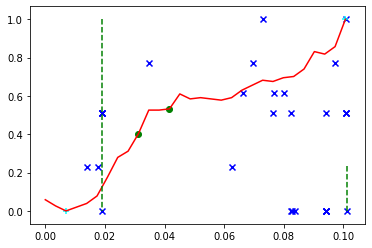

[0.53246753 0.4025974 ]
[0.08959222 0.16363637]
[0.04166667 0.03125   ]


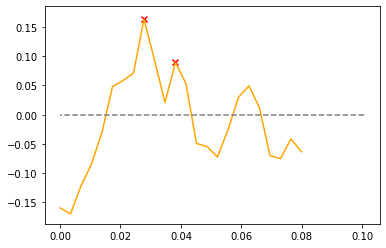

         min      mean       max      next       var
15  0.175325  0.338961  0.525974  0.584416  0.017528
14  0.077922  0.249351  0.402597  0.610390  0.015783
13  0.038961  0.176623  0.311688  0.532468  0.014366
[9.59893343]
0.10417824098840356


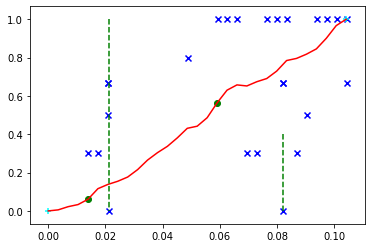

[0.06077348 0.56353591]
[0.0320442  0.11933702]
[0.01388889 0.05903935]


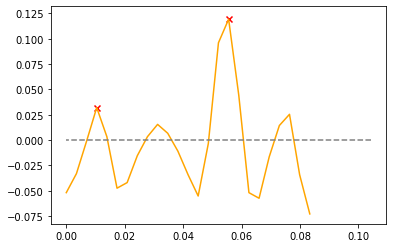

         min      mean       max      next       var
23  0.441989  0.555801  0.657459  0.729282  0.008419
22  0.430939  0.510497  0.629834  0.690608  0.007167
24  0.486188  0.597790  0.657459  0.784530  0.005287
[16.94117641]
0.05902777798473835


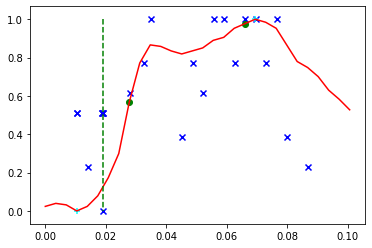

[0.97637795 0.56692913]
[0.18740159 0.50551181]
[0.06597222 0.02777778]


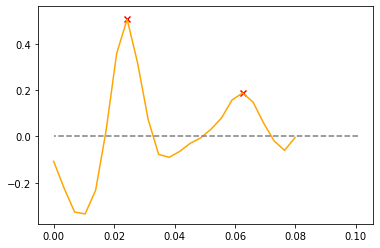

         min      mean       max      next       var
15  0.173228  0.535433  0.866142  0.834646  0.088288
14  0.078740  0.377953  0.771654  0.818898  0.082088
16  0.299213  0.672441  0.866142  0.850394  0.058082
[22.15384616]
0.04513888887595385


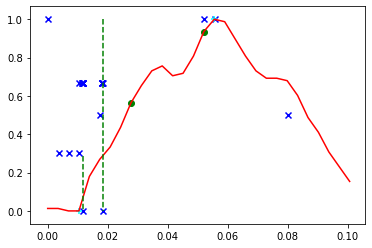

[0.56410256 0.93589744]
[0.23589744 0.36410257]
[0.02777778 0.05208333]


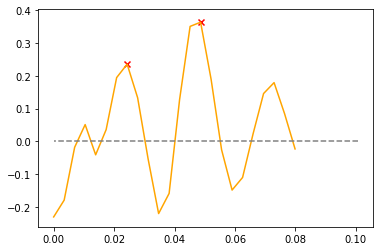

         min      mean       max      next       var
12  0.000000  0.243590  0.435897  0.756410  0.027285
15  0.333333  0.543590  0.730769  0.807692  0.025855
14  0.269231  0.451282  0.653846  0.717949  0.025263
[0.]
0.0


IndexError: list index out of range

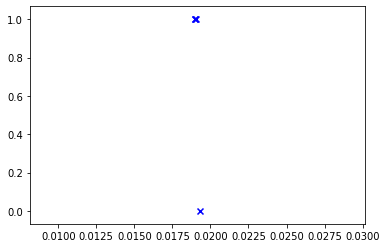

In [40]:
# reading = 0
for i in range(0, len(cgmSeries_np)):
    print(slopes[i])
    print(time_diffs[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    plt.scatter(peak_times[i], peak_values[i], marker='o', c='green')
    plt.scatter(cgmSeries_np[i][maxs[i]], cgmNorm_np[i][maxs[i]], marker='+', c='cyan')
    plt.scatter(cgmSeries_np[i][mins[i]], cgmNorm_np[i][mins[i]], marker='+', c='cyan')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()
#     plt.figure()
#     plt.plot(cgmSeries_np[i][:-window_size], vels[i], c='blue')
#     plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
#     plt.show()
#     plt.figure()
#     plt.plot(cgmSeries_np[i][:-2*window_size], accs[i], c='pink')
#     plt.show()
    print(peak_values[i])
    print(peak_heights[i])
    print(peak_times[i])
    plt.figure()
    plt.plot(cgmSeries_np[i][reg_window_size:], reg_errors[i], c='orange')
    plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
    plt.scatter(peak_time_diffs[i], peak_heights[i], c='red', marker='x')
    plt.show()
    
    # Windowed features
    window_input = DataFrame(cgmNorm_np[i][::-1])
    width=5
    shifted=window_input.shift(width - 1)
    window=shifted.rolling(window=width)
    dataframe=concat([window.var(), window.min(), window.mean(), window.max() ], axis=1)
    dataframe.columns = ['var', 'min', 'mean', 'max']
    window_features=dataframe.nlargest(3,'var')
    print(window_features)